## Генерация текста с помощью RNN

Поставим задачу: необходимо сгенерировать научный текст.

В качестве датасета возьмем [выгрузку статей из Arxiv](https://www.kaggle.com/datasets/Cornell-University/arxiv). Используем версию 175 (4.13 GB).

Метрику качества выберем "на глаз".

Модель возьмем RNN, функция потерь будет кросс-энтропия, оптимизатор Adam.

Модель будет предсказывать следующий токен. Кросс-энтропию будем считать над вероятностью реального токена.

In [1]:
from random import sample

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import wandb
from torch.optim import Adam

### Токенизация

В качестве токена в этой задаче будем брать **один символ**.

In [2]:
# BOS — символ начала текста, EOS — символ конца текста
BOS, EOS = " ", "\n"

data = pd.read_json("small-data.json", lines=True)
lines = (
    data.apply(lambda row: (row["title"] + " ; " + row["abstract"])[:512], axis=1)
    .apply(lambda line: BOS + line.replace(EOS, " ") + EOS)
    .tolist()
)

In [3]:
lines[0]

' Calculation of prompt diphoton production cross sections at Tevatron and   LHC energies ;   A fully differential calculation in perturbative quantum chromodynamics is presented for the production of massive photon pairs at hadron colliders. All next-to-leading order perturbative contributions from quark-antiquark, gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as all-orders resummation of initial-state gluon radiation valid at next-to-next-to-leading logarithmic accuracy. The region o\n'

In [4]:
tokens = {char for line in lines for char in line}

In [5]:
char2idx = {token: i for i, token in enumerate(sorted(tokens))}

In [6]:
char2idx['<BOS>'] = 100
char2idx['<EOS>'] = 101
char2idx['<PAD>'] = 102

In [7]:
char2idx.keys()

dict_keys(['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x7f', '\x80', '\x99', 'â', '<BOS>', '<EOS>', '<PAD>'])

In [8]:
def to_tensor_pad(lines: list[str],
                  max_seq_len: int | None = None,
                  BOS=char2idx['<BOS>'],
                  EOS=char2idx['<EOS>'],
                  PAD=char2idx['<PAD>']):
    lines = [[BOS] + [char2idx[char] for char in line] + [EOS] for line in lines]
    max_seq_len = max_seq_len or max(map(len, lines))
    tensor_pad = torch.full([len(lines), max_seq_len], fill_value=PAD)
    for i, line in enumerate(lines):
        truncated = line[:max_seq_len]
        tensor_pad[i, :len(truncated)] = torch.tensor(truncated, dtype=torch.int32)
    return tensor_pad

to_tensor_pad(['23ed', 'wef34f3433'])

tensor([[100,  19,  20,  70,  69, 101, 102, 102, 102, 102, 102, 102],
        [100,  88,  70,  71,  20,  21,  71,  20,  21,  20,  20, 101]])

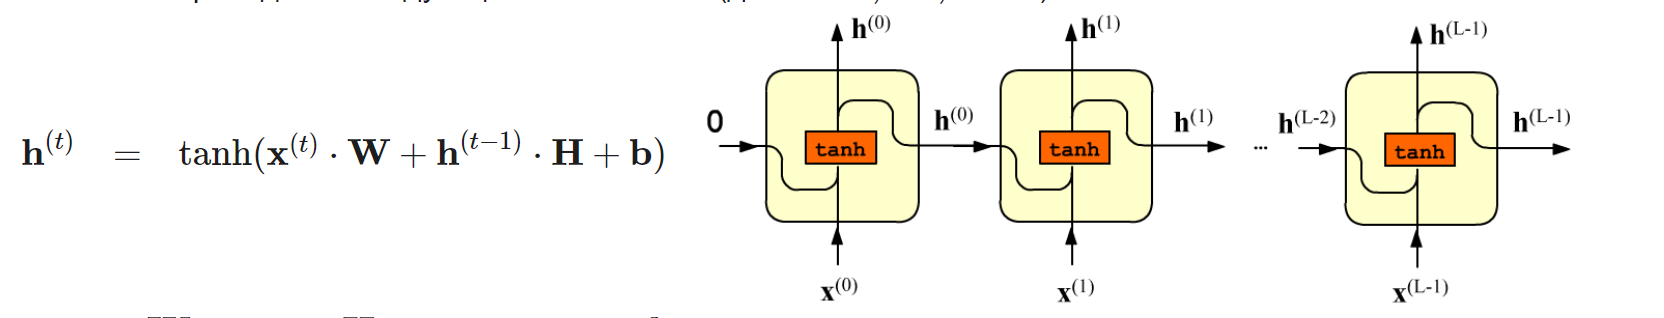

In [10]:
class MyRnnLayer(nn.Module):
    # tanh(W_x * x + W_h * h + b_x + b_h) = tanh(W_x * x + b_x     +     W_h * h + b_h)
    def __init__(self, in_dim: int, hid_size: int):
        super().__init__()
        self.hid_size = hid_size
        self.input_linear_layer = nn.Linear(
            in_features=in_dim, out_features=hid_size, bias=True
        )
        self.hidden_state_linear_layer = nn.Linear(
            in_features=hid_size, out_features=hid_size, bias=True
        )
        self.activation = nn.Tanh()

    def forward(self, x: torch.Tensor, state: torch.Tensor | None = None):
        assert x.ndim == 3  # (bs, n_tokens, token_dim)
        if state is None:
            state = torch.zeros((x.shape[0], self.hid_size), device=x.device)
        states = [state]
        for i in range(x.shape[1]):
            states.append(
                self.activation(
                    self.input_linear_layer(x[:, i, :])
                    + self.hidden_state_linear_layer(states[-1])
                )
            )
        return torch.stack(states[1:]).permute((1, 0, 2)), states[-1][None, ...]


my_rnn = MyRnnLayer(10, 32)
test_input = torch.randn((5, 12, 10))
test_output = my_rnn(test_input)
test_output[0].shape, test_output[1].shape

(torch.Size([5, 12, 32]), torch.Size([1, 5, 32]))

In [87]:
class RnnLanguage(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim):
        super().__init__()
        self.vocab_size, self.emb_dim, self.hidden_dim = vocab_size, emb_dim, hidden_dim
        self.emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=emb_dim)
        self.rnn = nn.RNN(input_size=emb_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_dim, out_features=vocab_size) # (N, vocab_size)
        
    def forward(self, x):
        # x [N, seq_len]
        rv = self.emb(x) # x [N, seq_len, Emb]
        rv = self.rnn(rv)[0] # x [N, seq_len, H]
        rv = self.fc(rv) # x [N, seq_len, vocab_size]
        return rv
# внутри to_tensor_pad добавляется еще 2 токена начала и конца
model = RnnLanguage(vocab_size=102, emb_dim=30, hidden_dim=43)
model(to_tensor_pad(["in this article we"])).shape    

torch.Size([1, 20, 102])

In [88]:
VOCAB_SIZE = len(char2idx)
EMB_SIZE = 128
HIDDEN_SIZE = 128
NUM_EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
MAX_SEQ_LEN = 100  # Или другое значение, в зависимости от ваших данных

model = RNNLanguage(vocab_size=VOCAB_SIZE, emb_size=EMB_SIZE, hidden_size=HIDDEN_SIZE)

criterion = nn.CrossEntropyLoss(ignore_index=char2idx['<PAD>'])
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

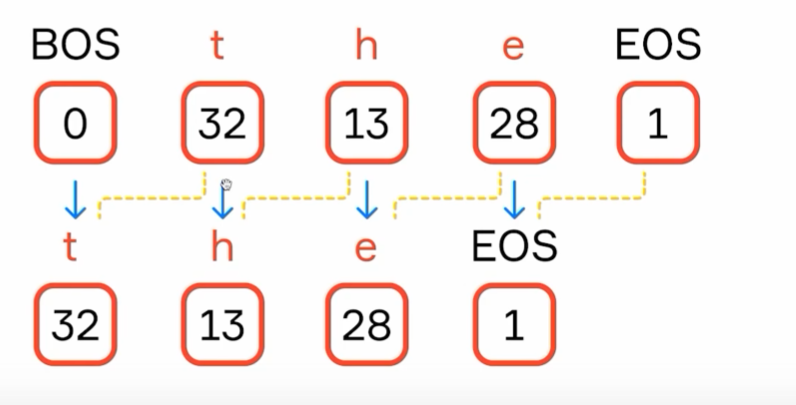

In [89]:
BATCH_SIZE = 64
EPOCHS = 10
def train_loop(model: nn.Module, train_lines: list[str]):
    clip_norm = 1e5
    loss_train = []
    model.to('cpu')
    N_BATCHES = len(train_lines) // BATCH_SIZE
    for epoch in range(EPOCHS):
        model.train()
        loss_epoch = 0.0
        random.shuffle(train_lines)
        with tqdm.tqdm(total=N_BATCHES, desc=f"Epoch {epoch+1}/{EPOCHS}") as pbar:
            for i in range(0, len(train_lines), BATCH_SIZE):
                lines = train_lines[i:BATCH_SIZE+i]
                inputs = to_tensor_pad(lines, max_seq_len=100)
                
                targets = inputs[:, 1:].contiguous()
                inputs = inputs[:, :-1].contiguous()
                
                opt.zero_grad()
                
                predicted = model(inputs)
                loss = criterion(predicted.view(-1, VOCAB_SIZE), targets.view(-1))
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
                opt.step()
                
                loss_epoch += loss.item()
                pbar.set_postfix({'loss': loss.item()})
                pbar.update(1)
            
        avg_loss_epoch = loss_epoch / N_BATCHES
        loss_train.append(avg_loss_epoch)
        print(f"Epoch {epoch+1} Average Loss: {avg_loss_epoch}")
    return loss_train

train_loop(model, lines[:5000])

Epoch 1/10: 79it [00:06, 12.01it/s, loss=2.54]                                                                         


Epoch 1 Average Loss: 3.051526760443663


Epoch 2/10: 79it [00:06, 12.06it/s, loss=2.14]                                                                         


Epoch 2 Average Loss: 2.3965880473454795


Epoch 3/10:  55%|████████████████████████████████▌                          | 43/78 [00:03<00:02, 11.77it/s, loss=2.15]


KeyboardInterrupt: 

#### Функция потерь
Модель выдает вероятности каждого токена из словаря для каждого слова.
Будем учить модель предсказывать следующий токен при условии всех предыдущих.

![pic](./pic.jpg)

Формула функции потерь:
$$
L = - \cfrac{1}{N} \sum_{i=1}^N \ln p(x_t^{(i)} | x_{t-1}^{(i)}, \dots, x_1^{(i)})
$$
где $N$ — размер батча.

#### Генерация
Поскольку модель выдает вектор вероятностей каждого токена в предложении, то для генерации одного текста поступим так:
1. Берем вектор `(batch_size = 1, n_words, emb_dim)` из выхода модели, берем последнюю координату из `n_words`.
2. Из полученного вектора `(1, emb_dim)` вероятностей решаем, как получить следующий токен.

Существует два варианта того, как можно получить следующий токен:
1. Отобрать тот, у кого самая большая вероятность — это **жадный выбор** (greedy sampling). Просто берем `argmax`.
2. Взять случайный с учетом вероятностей.
Модель выдает логиты — к ним применим softmax и получим вероятности.
Пример сэмплирования: в векторе `[0.1, 0.3, 0.6]` первая координата будет выбрана с вероятностью 10%, вторая — с 30%, третья — с 60%.
Это называется **случайное сэмплирование с учетом вероятностей**.
3. Взять идею из п.2, но перед сэмплированием перевзвесить все логиты:
$$
p(l_i) = \cfrac{\exp(l_i / \tau)}{\sum_{i=1}^D \exp(l_i / \tau)}
$$
где $D$ — мощность словаря, число уникальных токенов, $l_i$ — логит для $i$-го токена, $\tau$ — некоторый параметр, называемый **температурой**.

Это называется **сэмплирование с температурой**.
Варьируя температуру, можно либо перейти в жадный выбор, либо в равновероятный выбор токенов.

Мы будем использовать п.1 и п.3 для сэмплирования.

In [91]:
def generate(
    model: nn.Module,
    prefix: str = 'learning',
    temperature: float = 1.0,
    max_len=100):
    
    with torch.no_grad():
        while True:
            logits = model(to_tensor_pad([prefix]))
            print(f'Выходная размерность логитов после модели: {logits.shape}')
            print(f'Выходная размерность логитов выбора 0 батча и последнего элемента токена: {logits[0, -1].shape}')
            logits = logits[0, -1]
            if temperature != 1.0:
                logits = logits / temperature 
            probs = torch.softmax(logits, dim=-1).numpy()
            
            
            if temperature == 0:
                next_token = char2idx[np.argmax(probs)]
            else:
                next_token = np.random.choice(list(char2idx.keys()), p=probs)
            
            prefix += next_token
            
            if next_token == '<EOS>' or len(prefix) > max_len:
                break
    return prefix
generate(model)

Выходная размерность логитов после модели: torch.Size([1, 10, 103])
Выходная размерность логитов выбора 0 батча и последнего элемента токена: torch.Size([103])
Выходная размерность логитов после модели: torch.Size([1, 11, 103])
Выходная размерность логитов выбора 0 батча и последнего элемента токена: torch.Size([103])
Выходная размерность логитов после модели: torch.Size([1, 12, 103])
Выходная размерность логитов выбора 0 батча и последнего элемента токена: torch.Size([103])
Выходная размерность логитов после модели: torch.Size([1, 13, 103])
Выходная размерность логитов выбора 0 батча и последнего элемента токена: torch.Size([103])
Выходная размерность логитов после модели: torch.Size([1, 14, 103])
Выходная размерность логитов выбора 0 батча и последнего элемента токена: torch.Size([103])
Выходная размерность логитов после модели: torch.Size([1, 15, 103])
Выходная размерность логитов выбора 0 батча и последнего элемента токена: torch.Size([103])
Выходная размерность логитов после модел

'learningoshad1 a q\\tooslgsegUi ;  nmLato isra osrlsadY/ soaMi bI Zokwrucamt(o oosor<EOS>'